In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e1_general_model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocationsUncorrelated']
num_samples = data['num_samples']
device_count = data['device_count']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_received_signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/e1_communication_simulation_general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
num_samples=10

Correlation Aware Sparse Bayesian Learning (CASBL)

In [4]:
def casbl_algorithm(A, y, N, sig2e, Tau_p, loc, max_iter=1000, stopping_criterion=1e-4, inner_max_iter=20, gradient_threshold=1e-6):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    alpha = 0.5
    kappa = 5.725
    D = 20

    M = y.shape[1]  # Number of antennas

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if kappa == 0:
        G = np.eye(N, dtype=np.complex128)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = (np.exp(- distance_matrix / kappa) - np.exp(-D / kappa)) / (1 - np.exp(-D / kappa))

        # Compute G as the inverse of the correlation matrix
        G = np.linalg.solve(correlation_matrix, np.eye(correlation_matrix.shape[0], dtype=np.complex128))

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Gamma_inv = np.linalg.solve(Gamma, np.eye(Gamma.shape[0]))
        Sigma_x_inv = (1/sig2e) * A.conj().T @ A + Gamma_inv
        Sigma_x = np.linalg.solve(Sigma_x_inv, np.eye(Sigma_x_inv.shape[0], dtype=np.complex128))
        mu_x = (1/sig2e) * Sigma_x @ A.conj().T @ y

        # Compute Q using posterior mean and covariance
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # **Inner Loop for Maximization of Gamma (Relevance Parameters)**
        gamma_old = np.diag(Gamma)
        Gamma_old = np.diagflat(gamma_old)
        for inner_iter in range(inner_max_iter):
            # Compute gradient (change in gamma)
            gradient = (
                (2 * alpha * gamma_old**2 * (G @ gamma_old) + gamma_old - Q)
                /
                (4 * alpha * gamma_old * (G @ gamma_old) + 1)
            )

            # Update gamma using gradient step
            gamma_new = gamma_old - gradient

            # Ensure non-negativity (numerical stability)
            gamma_new = np.maximum(gamma_new, 1e-8)

            # Check for convergence in the inner loop based on gradient norm
            if np.linalg.norm(gradient) < gradient_threshold:
                break

            # Update gamma_old for the next inner iteration
            gamma_old = gamma_new

        # After inner loop, update Gamma
        Gamma = np.diagflat(gamma_new)

        # Check for convergence in the outer loop (not based on inner loop completion)
        if np.linalg.norm(np.diag(Gamma_old) - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for casbl results
z_casbl = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # casbl results
gamma_casbl = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # casbl gamma values
hit_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # Hit rate for casbl
miss_detection_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # Miss detection rate for casbl
false_alarm_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # False alarm rate for casbl
norm_mse_casbl = np.zeros((num_samples, len(snr_db_array)))  # Norm MSE for casbl

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply CASBL algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_algorithm(theta, received_signal, device_count, noise_power, pilot_length, loc)

        # Store the results
        z_result[gamma_result <= 0.05] = 0
        z_casbl[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_casbl[sample_index, snr_db_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for CASBL
        hit_rate_casbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the miss detection rate for CASBL
        miss_detection_rate_casbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 0) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the false alarm rate for CASBL
        false_alarm_rate_casbl[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for CASBL
        norm_mse_casbl[sample_index, snr_db_index] = (
            np.linalg.norm(z - z_result)**2 / max(1e-10, np.linalg.norm(z)**2)
        )


Processing SNR Levels:  17%|█▋        | 1/6 [01:26<07:12, 86.60s/it]

Converged after 967 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [04:29<04:30, 90.14s/it]

Converged after 968 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [01:31<07:37, 91.47s/it]

Converged after 981 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [03:05<06:12, 93.15s/it]

Converged after 993 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [07:37<01:30, 90.90s/it]

Converged after 920 outer iterations



Processing Samples:  40%|████      | 4/10 [37:28<55:53, 558.99s/it]  

Converged after 966 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [01:34<07:53, 94.75s/it]

Converged after 978 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [03:00<05:58, 89.52s/it]

Converged after 855 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [06:12<03:06, 93.38s/it]

Converged after 953 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [04:28<04:24, 88.20s/it]

Converged after 869 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [01:26<07:14, 86.96s/it]

Converged after 919 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [01:16<06:23, 76.65s/it]

Converged after 870 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [07:20<01:27, 87.72s/it]

Converged after 866 outer iterations



Processing Samples: 100%|██████████| 10/10 [1:32:31<00:00, 555.15s/it]

Converged after 698 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hit_rate_casbl = np.mean(hit_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_miss_detection_rate_casbl = np.mean(miss_detection_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_casbl = np.mean(false_alarm_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_casbl = np.mean(norm_mse_casbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_casbl)
print("Average Miss Detection Rate across samples per SNR level:", avg_miss_detection_rate_casbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_casbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_casbl)

Average Hit Rate across samples per SNR level: [53. 69. 72. 80. 87. 87.]
Average Miss Detection Rate across samples per SNR level: [47. 31. 28. 20. 13. 13.]
Average False Alarm Rate across samples per SNR level: [7.46153846 5.12820513 4.05128205 2.79487179 1.66666667 1.61538462]
Average Normalized MSE across samples per SNR level: [0.8893074  0.71340677 0.62972712 0.46927346 0.31215226 0.29055365]


In [8]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/e1_results_uncorrelated_casbl_m2_snr_db.npz',
                    z_casbl=z_casbl,
                    gamma_casbl=gamma_casbl,
                    hit_rate_casbl=hit_rate_casbl,
                    miss_detection_rate_casbl=miss_detection_rate_casbl,
                    false_alarm_rate_casbl=false_alarm_rate_casbl,
                    norm_mse_casbl=norm_mse_casbl,
                    avg_hit_rate_casbl=avg_hit_rate_casbl,
                    avg_miss_detection_rate_casbl=avg_miss_detection_rate_casbl,
                    avg_false_alarm_rate_casbl=avg_false_alarm_rate_casbl,
                    avg_norm_mse_casbl=avg_norm_mse_casbl,
                    pilot_length=pilot_length,
                    snr_db_array=snr_db_array)

print("All results have been saved")

All results have been saved


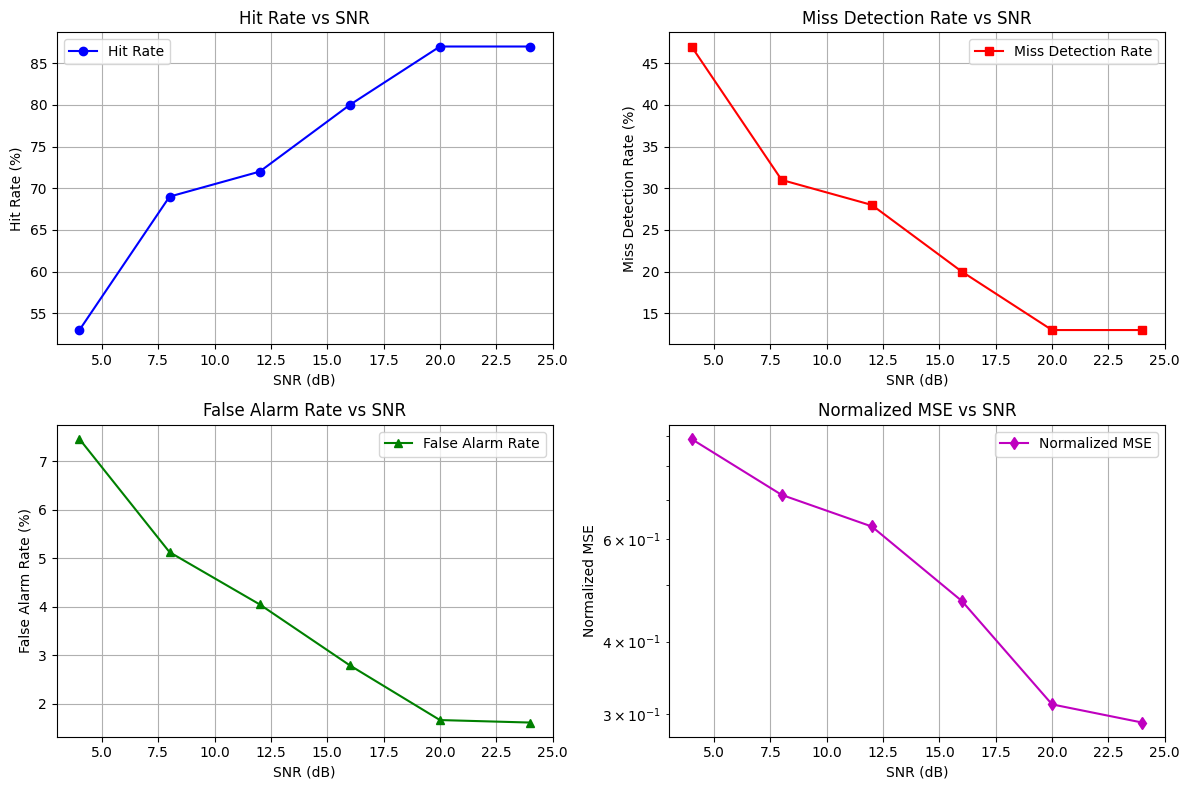

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(snr_values, avg_hit_rate_casbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(snr_values, avg_miss_detection_rate_casbl, marker='s', linestyle='-', color='r', label='Miss Detection Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Miss Detection Rate (%)")
plt.title("Miss Detection Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(snr_values, avg_false_alarm_rate_casbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(snr_values, avg_norm_mse_casbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_casbl_vs_ground_truth(casbl_results, Z, sample_index, snr_index, snr_value):
    """Plot casbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # casbl Estimated Signal
    plt.plot(np.abs(casbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="casbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"casbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

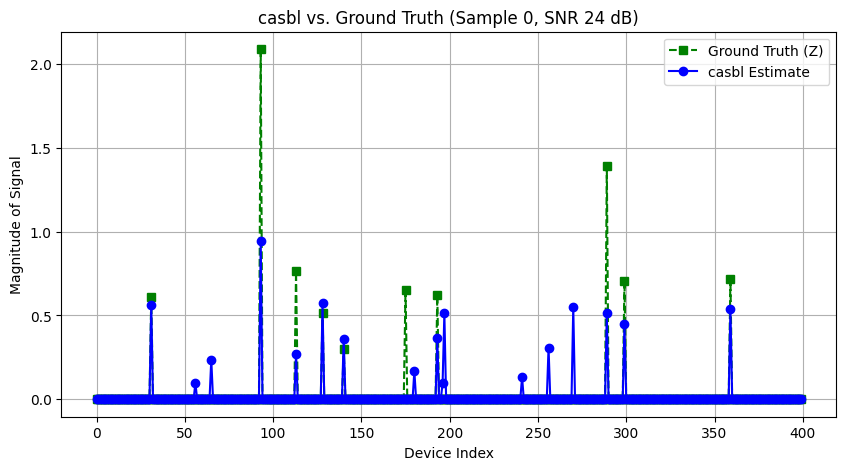

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_casbl_vs_ground_truth(z_casbl, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_casbl_vs_ground_truth(gamma_casbl, gamma_true, sample_index, snr_index, snr_value):
    """Plot casbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot casbl estimated gamma
    plt.stem(device_indices, gamma_casbl[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="casbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (casbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


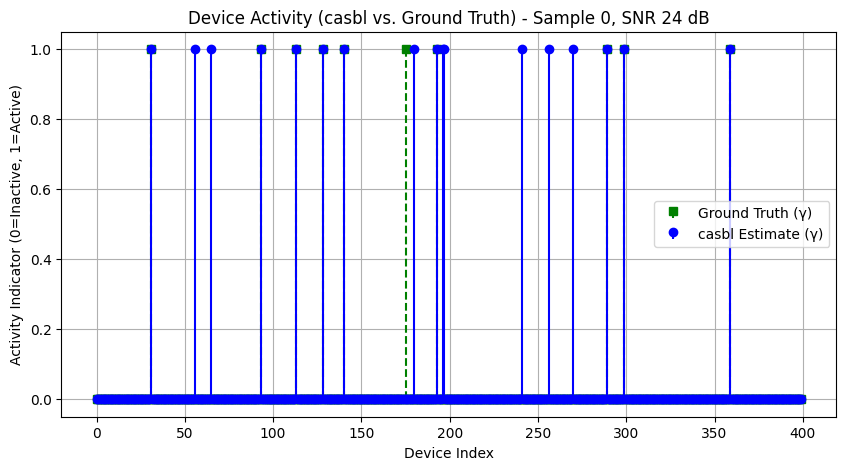

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_casbl_vs_ground_truth(gamma_casbl, all_gamma, sample_index, snr_index, snr_value)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


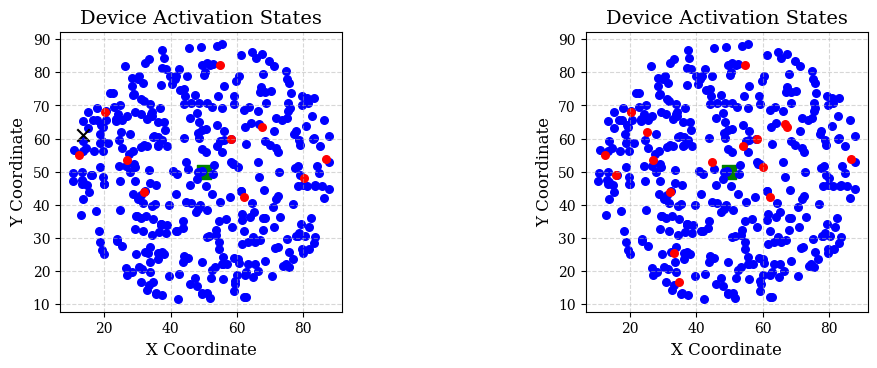

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

plt.rcParams['font.family'] = 'serif'

# Set figure size and layout
plt.figure(figsize=(12, 8))  # Larger figure for clarity

# Load saved data
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e1_general_model.npz', allow_pickle=True)

# Select sample index (modify if needed)
sample_index = 0
snr_index = 5  # Choose a specific SNR index

# Extract data from the saved file
EventCount = data['all_EventCount'][sample_index]
DeviceActiveCount = data['all_DeviceActiveCount'][sample_index]
DeviceProbability = data['all_DeviceProbability'][sample_index]
DeviceAlarmStatus = data['all_DeviceAlarmStatus'][sample_index]
DeviceStatus = data['all_DeviceStatus'][sample_index].astype(bool)  # Ensure boolean type
DeviceLocations = data['all_DeviceLocations'][sample_index]
DeviceLocationsUncorrelated = data['all_DeviceLocationsUncorrelated'][sample_index]
DeviceLocationsPolar = data['all_DeviceLocationsPolar'][sample_index]
EventLocations = data['all_EventLocations'][sample_index]
EventLocationsPolar = data['all_EventLocationsPolar'][sample_index]

# Extract X, Y coordinates for devices and events
xD, yD = DeviceLocations[:, 0], DeviceLocations[:, 1]
xDu, yDu = DeviceLocationsUncorrelated[:, 0], DeviceLocationsUncorrelated[:, 1]
xE, yE = EventLocations[:, 0], EventLocations[:, 1]

# Load base station location
bs_location = data['bs_location']

# **Subplot 1: Device Active States**
plt.subplot(2, 2, 1)
plt.scatter(bs_location[0], bs_location[1], color='g', marker='s', label='Base Station', s=100)  # Base Station
# Devices that are inactive
plt.scatter(xDu[~all_gamma[sample_index]], yDu[~all_gamma[sample_index]], color='b', label='Inactive Devices', s=30)
# Devices that are active
plt.scatter(xDu[all_gamma[sample_index]], yDu[all_gamma[sample_index]], color='r', label='Active Devices', s=30)
plt.scatter(xE, yE, color='k', marker='x', label='Events', s=80)  # Events with moderate marker size
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')  # Square aspect ratio
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('Device Activation States', fontsize=14)

# **Subplot 2: Device Active States (Uncorrelated)**
plt.subplot(2, 2, 2)
plt.scatter(bs_location[0], bs_location[1], color='g', marker='s', label='Base Station', s=100)  # Base Station
# Devices that are inactive
plt.scatter(xDu[~gamma_casbl[sample_index, snr_index]], yDu[~gamma_casbl[sample_index, snr_index]], color='b', label='Inactive Devices', s=30)
# Devices that are active
plt.scatter(xDu[gamma_casbl[sample_index, snr_index]], yDu[gamma_casbl[sample_index, snr_index]], color='r', label='Active Devices', s=30)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_aspect('equal', adjustable='box')  # Square aspect ratio
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('Device Activation States', fontsize=14)

# Adjust the layout to add a gap between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust the width space between subplots

# Show plot
plt.show()
